In [31]:
## Import packages
import os
import mne
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfiltfilt, sosfreqz  
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_curve, auc

import scripts.classification_utils as utils
import scripts.CSP as csp
import scripts.SACSP as sacsp

In [46]:
%config InlineBackend.figure_format = 'retina'
dpi=300

**<font color='red'>Note</font>: set the following variable to enable or disable using ICA-processed data**

In [82]:
use_ica = False

In [83]:
## Define directories
data_dir = '/home/inffzy/Desktop/cogs189/cogs189_final_project/data'
results_dir = '/home/inffzy/Desktop/cogs189/cogs189_final_project/results'

In [84]:
## Raw data directory names
bc4_2a_processed_name = 'bci_competition_4_2a_processed'
bc3_3a_processed_name = 'bci_competition_3_3a_processed'

## Create list of all data paths
bc4_2a_processed_data_paths = []
bc3_3a_processed_data_paths = []

## Add bc4_2a data paths
for subject_idx in range(1, 10):
    subject_name = 'A0' + str(subject_idx) + 'T'
    if use_ica:
        subject_name += '_ica'
    bc4_2a_processed_data_paths.append(
        os.path.join(data_dir, bc4_2a_processed_name, subject_name + '.npz'))
    
## Add bc3_3a data paths
for subject_idx in range(1, 4):
    subject_name = 'bc3_3a_s' + str(subject_idx)
    if use_ica:
        subject_name += '_ica'
    bc3_3a_processed_data_paths.append(
        os.path.join(data_dir, bc3_3a_processed_name, subject_name + '.npz'))
    
all_data_paths = bc4_2a_processed_data_paths + bc3_3a_processed_data_paths

In [85]:
## Define constants
sampling_f = 250
label_left_hand = 769
label_right_hand = 770
num_samples = 10
test_split = 0.33
random_state = 42
num_cross_val = 5
num_experiment = 10

## Visualizing CSP on BC4_2a Subject 1

### Before and after CSP Transform

In [86]:
## Load data
data_npz = np.load(all_data_paths[0])
data = data_npz['processed_motor_imagery_data']
labels = data_npz['descriptions']

## Extract left and right hand epochs
data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]

print(data.shape)
print(labels.shape)

(138, 22, 500)
(138,)


(138, 22)


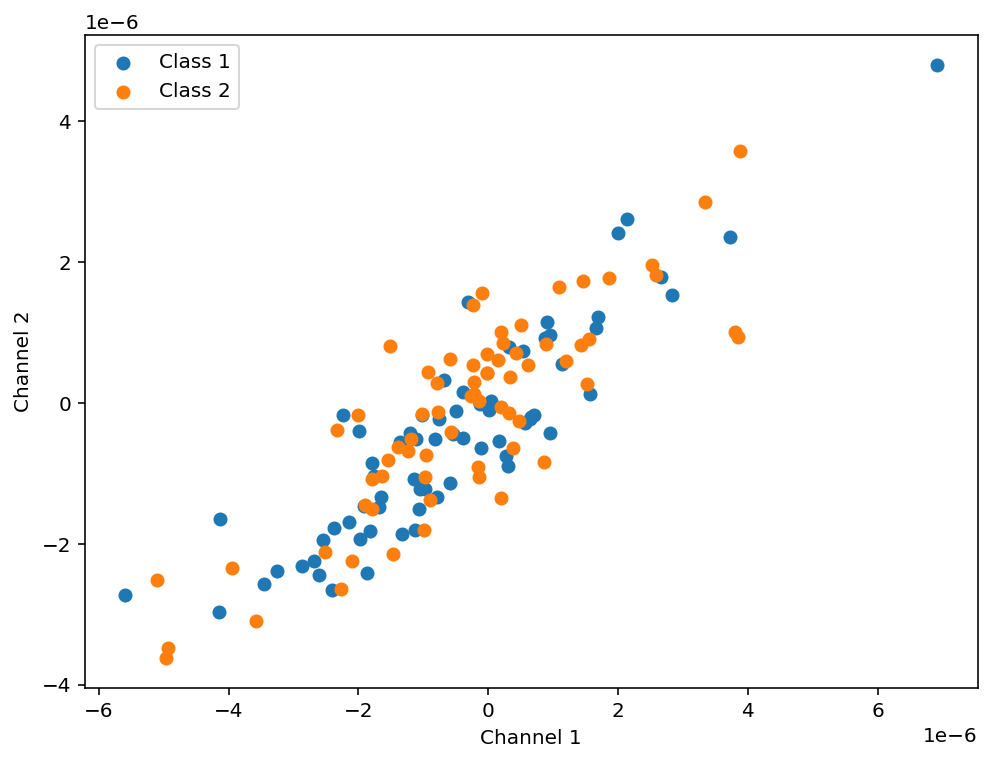

In [87]:
## Plot data before CSP transform
data_ds = np.mean(data, axis=-1)
print(data_ds.shape)

data_ds_c1 = data_ds[labels == label_left_hand]
data_ds_c2 = data_ds[labels == label_right_hand]

plt.figure(figsize=(8, 6))
plt.scatter(data_ds_c1[:, 0], data_ds_c1[:, 1], label='Class 1')
plt.scatter(data_ds_c2[:, 0], data_ds_c2[:, 1], label='Class 2')
plt.xlabel('Channel 1')
plt.ylabel('Channel 2')
plt.legend()

vis_name = 'before_CSP'
if use_ica:
    vis_name += '_ica'
plt.savefig(os.path.join(results_dir, vis_name + '.png'), dpi=dpi)

(138, 2, 500)
(138, 2)


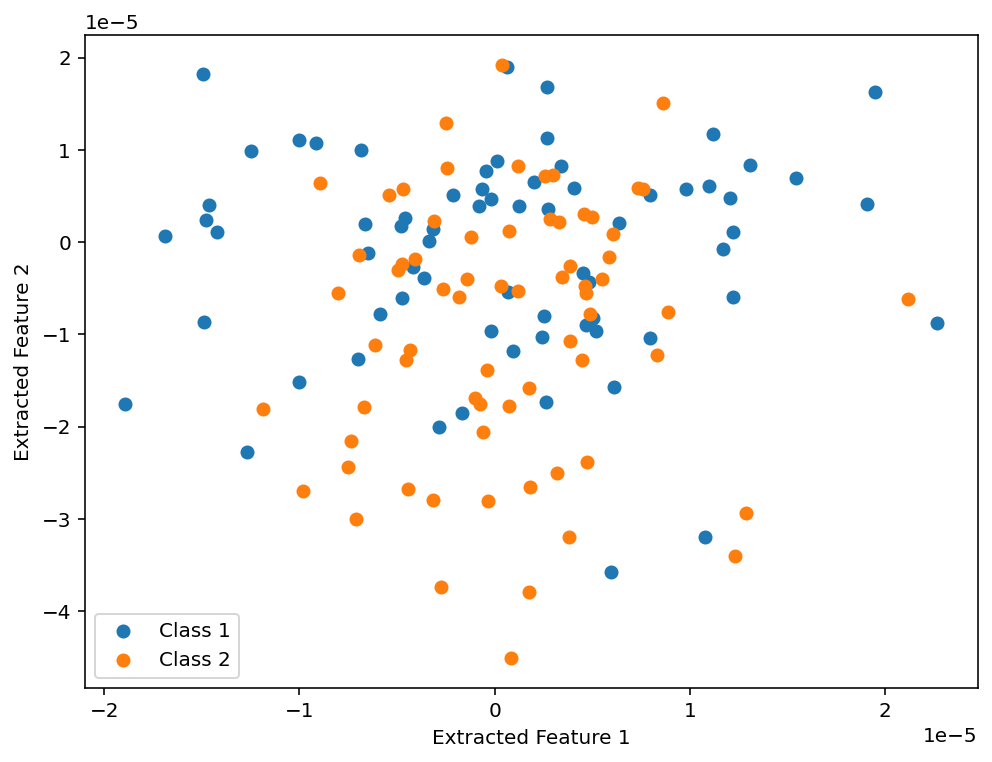

In [88]:
## Plot data after CSP transform
data_c1 = data[labels == label_left_hand]
data_c2 = data[labels == label_right_hand]

csp_transform = csp.CSP(data_c1, data_c2, n_top=1)
data_ = csp.apply_CSP_transform(data, csp_transform)

print(data_.shape)

data_ds = np.mean(data_, axis=-1)
print(data_ds.shape)

data_ds_c1 = data_ds[labels == label_left_hand]
data_ds_c2 = data_ds[labels == label_right_hand]

plt.figure(figsize=(8, 6))
plt.scatter(data_ds_c1[:, 0], data_ds_c1[:, 1], label='Class 1')
plt.scatter(data_ds_c2[:, 0], data_ds_c2[:, 1], label='Class 2')
plt.xlabel('Extracted Feature 1')
plt.ylabel('Extracted Feature 2')
plt.legend()

vis_name = 'after_CSP'
if use_ica:
    vis_name += '_ica'
plt.savefig(os.path.join(results_dir, vis_name + '.png'), dpi=dpi)

In [89]:
## Visualize spatial filters

## Visualizing SACSP on BC4_2a Subject 1

In [90]:
## Load data
data_npz = np.load(all_data_paths[0])
data = data_npz['processed_motor_imagery_data']
labels = data_npz['descriptions']

## Extract left and right hand epochs
data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]

print(data.shape)
print(labels.shape)

(138, 22, 500)
(138,)


(69, 6)
(69, 6)


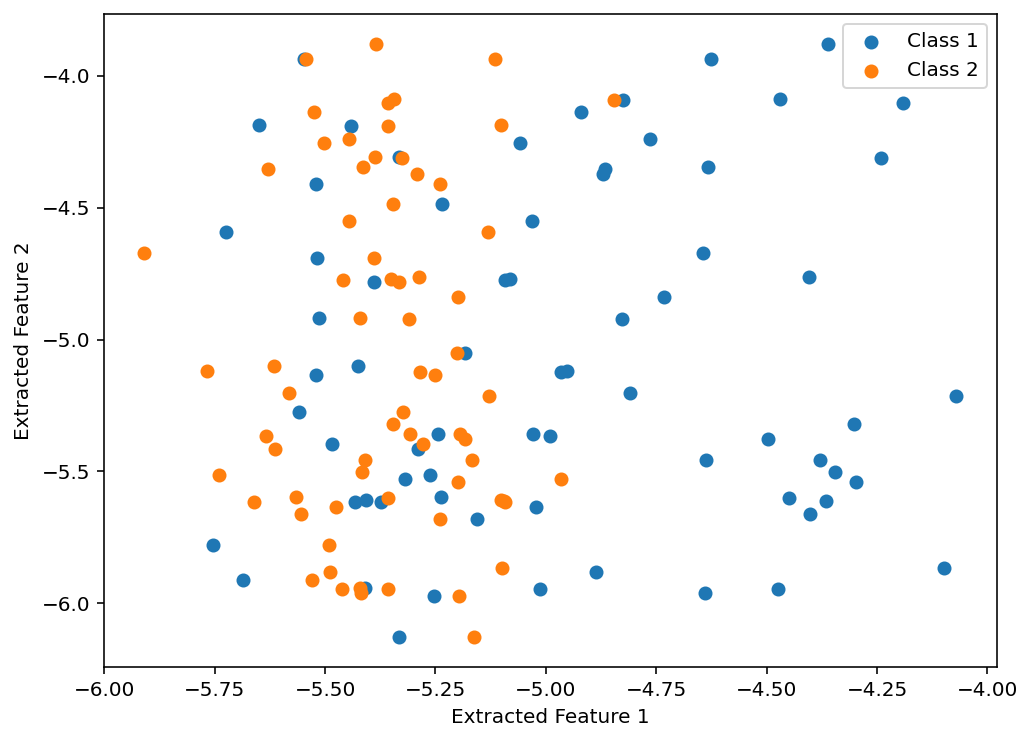

In [91]:
## Plot data after SACSP transform
data_c1 = data[labels == label_left_hand]
data_c2 = data[labels == label_right_hand]

c1_filter_pairs, c2_filter_pairs = sacsp.SACSP2(data_c1, data_c2)
extracted_features_c1 = sacsp.SACSP2_extract_features(data_c1, c1_filter_pairs, c2_filter_pairs)
extracted_features_c2 = sacsp.SACSP2_extract_features(data_c2, c1_filter_pairs, c2_filter_pairs)

print(extracted_features_c1.shape)
print(extracted_features_c2.shape)

plt.figure(figsize=(8, 6))
plt.scatter(extracted_features_c1[:, 0], extracted_features_c2[:, -1], label='Class 1')
plt.scatter(extracted_features_c2[:, 0], extracted_features_c2[:, -1], label='Class 2')
plt.xlabel('Extracted Feature 1')
plt.ylabel('Extracted Feature 2')
plt.legend()

vis_name = 'after_SACSP'
if use_ica:
    vis_name += '_ica'
plt.savefig(os.path.join(results_dir, vis_name + '.png'), dpi=dpi)

/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/inffzy/.conda/envs/cogs189/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, fl

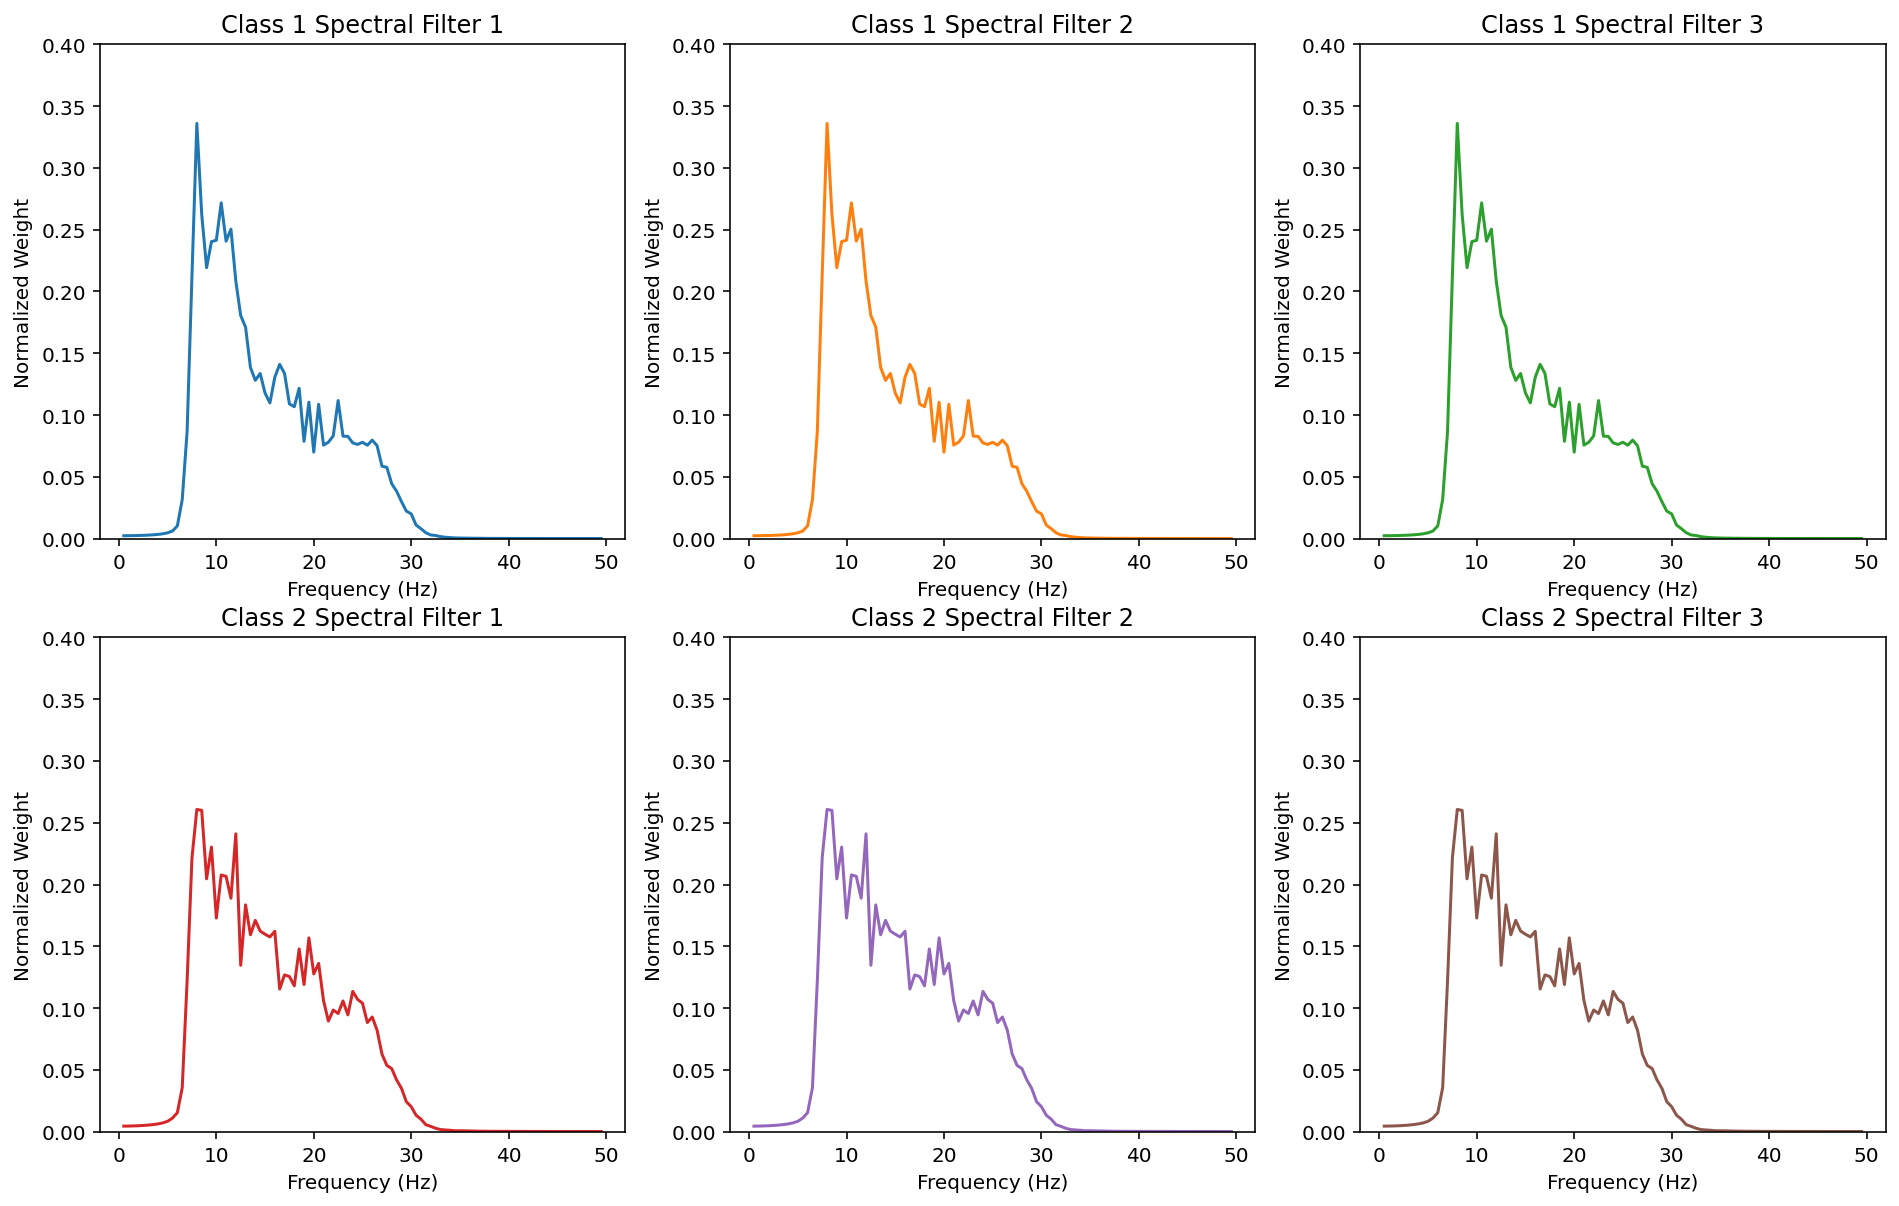

In [71]:
## Visualize spectral filters
data_c1 = data[labels == label_left_hand]
data_c2 = data[labels == label_right_hand]

c1_filter_pairs, c2_filter_pairs = sacsp.SACSP2(data_c1, data_c2)

c1_spectral_filter1 = c1_filter_pairs[0][0][1:100]
c1_spectral_filter2 = c1_filter_pairs[1][0][1:100]
c1_spectral_filter3 = c1_filter_pairs[2][0][1:100]

c2_spectral_filter1 = c2_filter_pairs[0][0][1:100]
c2_spectral_filter2 = c2_filter_pairs[1][0][1:100]
c2_spectral_filter3 = c2_filter_pairs[2][0][1:100]

freq = np.fft.fftfreq(500) * sampling_f

fig, axs = plt.subplots(2, 3, figsize=(16, 10))
axs[0, 0].plot(freq[1:100], c1_spectral_filter1 / np.linalg.norm(c1_spectral_filter1), 'tab:blue')
axs[0, 1].plot(freq[1:100], c1_spectral_filter2 / np.linalg.norm(c1_spectral_filter2), 'tab:orange')
axs[0, 2].plot(freq[1:100], c1_spectral_filter3 / np.linalg.norm(c1_spectral_filter3), 'tab:green')
axs[1, 0].plot(freq[1:100], c2_spectral_filter1 / np.linalg.norm(c2_spectral_filter1), 'tab:red')
axs[1, 1].plot(freq[1:100], c2_spectral_filter2 / np.linalg.norm(c2_spectral_filter2), 'tab:purple')
axs[1, 2].plot(freq[1:100], c2_spectral_filter3 / np.linalg.norm(c2_spectral_filter3), 'tab:brown')

axs[0, 0].set_title('Class 1 Spectral Filter 1')
axs[0, 1].set_title('Class 1 Spectral Filter 2')
axs[0, 2].set_title('Class 1 Spectral Filter 3')
axs[1, 0].set_title('Class 2 Spectral Filter 1')
axs[1, 1].set_title('Class 2 Spectral Filter 2')
axs[1, 2].set_title('Class 2 Spectral Filter 3')

axs[0, 0].set_xlabel('Frequency (Hz)')
axs[0, 1].set_xlabel('Frequency (Hz)')
axs[0, 2].set_xlabel('Frequency (Hz)')
axs[1, 0].set_xlabel('Frequency (Hz)')
axs[1, 1].set_xlabel('Frequency (Hz)')
axs[1, 2].set_xlabel('Frequency (Hz)')

axs[0, 0].set_ylabel('Normalized Weight')
axs[0, 1].set_ylabel('Normalized Weight')
axs[0, 2].set_ylabel('Normalized Weight')
axs[1, 0].set_ylabel('Normalized Weight')
axs[1, 1].set_ylabel('Normalized Weight')
axs[1, 2].set_ylabel('Normalized Weight')

axs[0, 0].set_ylim([0, 0.4])
axs[0, 1].set_ylim([0, 0.4])
axs[0, 2].set_ylim([0, 0.4])
axs[1, 0].set_ylim([0, 0.4])
axs[1, 1].set_ylim([0, 0.4])
axs[1, 2].set_ylim([0, 0.4])

vis_name = 'SACSP_spectral_filters'
if use_ica:
    vis_name += '_ica'
plt.savefig(os.path.join(results_dir, vis_name + '.png'), dpi=dpi)

In [ ]:
c1_spatial_filter1 = c1_filter_pairs[0][1]
c1_spatial_filter2 = c1_filter_pairs[1][1]
c1_spatial_filter3 = c1_filter_pairs[2][1]

c2_spectral_filter1 = c2_filter_pairs[0][0]
c2_spatial_filter1 = c2_filter_pairs[0][1]

In [ ]:
plt.plot(c1_spatial_filter1)
plt.plot(c1_spatial_filter2)
plt.plot(c1_spatial_filter3)

In [ ]:
c1_spatial_filter1

In [ ]:
c1_spatial_filter2

### Note: each of the following classification experiment is run 10 times, each with a different random seed

## Binary Classification with LDA

In [19]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
        
        ## Extract left and right hand epochs
        data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
        labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
    
        ## Downsample with windowed means
        data_ds = utils.windowed_means(data, num_samples)
        
        ## Flatten data
        data_ds_flattened = utils.flatten_dim12(data_ds)
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data_ds_flattened, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = utils.LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_score_avg = clf.train_binary()
        predictions, train_accuracy = clf.test_binary()
        predictions, test_accuracy = clf.test_binary(X_test, y_test)
        results[j, i, :] = [train_accuracy, cross_val_score_avg, test_accuracy]

Cross validation score average:  0.5654970760233917
Training accuracy:  0.9565217391304348
Testing accuracy:  0.5217391304347826
Cross validation score average:  0.47368421052631576
Training accuracy:  0.8901098901098901
Testing accuracy:  0.4666666666666667
Cross validation score average:  0.5941520467836258
Training accuracy:  0.8901098901098901
Testing accuracy:  0.45652173913043476
Cross validation score average:  0.5470588235294118
Training accuracy:  0.9186046511627907
Testing accuracy:  0.4418604651162791
Cross validation score average:  0.44183006535947716
Training accuracy:  0.8837209302325582
Testing accuracy:  0.3953488372093023
Cross validation score average:  0.49333333333333335
Training accuracy:  0.9866666666666667
Testing accuracy:  0.42105263157894735
Cross validation score average:  0.5176470588235295
Training accuracy:  0.8876404494382022
Testing accuracy:  0.5454545454545454
Cross validation score average:  0.6026143790849673
Training accuracy:  0.9090909090909091
T

Cross validation score average:  0.3288888888888889
Training accuracy:  1.0
Testing accuracy:  0.44
Cross validation score average:  0.5809523809523809
Training accuracy:  1.0
Testing accuracy:  0.4375
Cross validation score average:  0.7466666666666667
Training accuracy:  1.0
Testing accuracy:  0.42857142857142855
Cross validation score average:  0.543859649122807
Training accuracy:  0.8695652173913043
Testing accuracy:  0.5434782608695652
Cross validation score average:  0.4385964912280701
Training accuracy:  0.8571428571428571
Testing accuracy:  0.4888888888888889
Cross validation score average:  0.6935672514619883
Training accuracy:  0.9340659340659341
Testing accuracy:  0.4782608695652174
Cross validation score average:  0.5359477124183006
Training accuracy:  0.872093023255814
Testing accuracy:  0.5116279069767442
Cross validation score average:  0.4875816993464053
Training accuracy:  0.813953488372093
Testing accuracy:  0.5348837209302325
Cross validation score average:  0.466666

In [20]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_name = '2_LDA'
if use_ica:
    results_name += '_ica'
    
results_path = os.path.join(results_dir, results_name + '.npy')
np.save(results_path, results)

[[[0.95652174 0.56549708 0.52173913]
  [0.89010989 0.47368421 0.46666667]
  [0.89010989 0.59415205 0.45652174]
  [0.91860465 0.54705882 0.44186047]
  [0.88372093 0.44183007 0.39534884]
  [0.98666667 0.49333333 0.42105263]
  [0.88764045 0.51764706 0.54545455]
  [0.90909091 0.60261438 0.54545455]
  [1.         0.545      0.58974359]
  [1.         0.43777778 0.56      ]
  [1.         0.42380952 0.5       ]
  [1.         0.41333333 0.5       ]]

 [[0.86956522 0.54327485 0.58695652]
  [0.89010989 0.46140351 0.48888889]
  [0.89010989 0.5619883  0.58695652]
  [0.91860465 0.54640523 0.46511628]
  [0.8372093  0.47581699 0.46511628]
  [0.97333333 0.56       0.52631579]
  [0.91011236 0.50392157 0.59090909]
  [0.93181818 0.47385621 0.68181818]
  [1.         0.57083333 0.48717949]
  [1.         0.54666667 0.48      ]
  [1.         0.55238095 0.375     ]
  [1.         0.58666667 0.5       ]]

 [[0.83695652 0.5        0.54347826]
  [0.86813187 0.51637427 0.33333333]
  [0.91208791 0.58362573 0.3913043

## Binary Classification with Regular CSP + LDA

In [21]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
        
        ## Extract left and right hand epochs
        data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
        labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = csp.CSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_score_avg = clf.train_binary()
        predictions, train_accuracy = clf.test_binary()
        predictions, test_accuracy = clf.test_binary(X_test, y_test)
        results[j, i, :] = [train_accuracy, cross_val_score_avg, test_accuracy]

Cross validation score average:  0.8140350877192981
Training accuracy:  0.8478260869565217
Testing accuracy:  0.717391304347826
Cross validation score average:  0.7263157894736841
Training accuracy:  0.7362637362637363
Testing accuracy:  0.6222222222222222
Cross validation score average:  0.967251461988304
Training accuracy:  0.967032967032967
Testing accuracy:  0.8913043478260869
Cross validation score average:  0.8013071895424837
Training accuracy:  0.8255813953488372
Testing accuracy:  0.4883720930232558
Cross validation score average:  0.6627450980392157
Training accuracy:  0.6627906976744186
Testing accuracy:  0.5813953488372093
Cross validation score average:  0.8533333333333333
Training accuracy:  0.92
Testing accuracy:  0.5263157894736842
Cross validation score average:  0.830718954248366
Training accuracy:  0.8314606741573034
Testing accuracy:  0.75
Cross validation score average:  0.9444444444444444
Training accuracy:  0.9545454545454546
Testing accuracy:  0.8636363636363636


Cross validation score average:  0.96
Training accuracy:  1.0
Testing accuracy:  0.6428571428571429
Cross validation score average:  0.7625730994152047
Training accuracy:  0.8260869565217391
Testing accuracy:  0.6521739130434783
Cross validation score average:  0.6807017543859649
Training accuracy:  0.7472527472527473
Testing accuracy:  0.4666666666666667
Cross validation score average:  0.9017543859649123
Training accuracy:  0.9340659340659341
Testing accuracy:  0.8695652173913043
Cross validation score average:  0.7326797385620915
Training accuracy:  0.7558139534883721
Testing accuracy:  0.5581395348837209
Cross validation score average:  0.6176470588235293
Training accuracy:  0.6627906976744186
Testing accuracy:  0.5581395348837209
Cross validation score average:  0.6799999999999999
Training accuracy:  0.7066666666666667
Testing accuracy:  0.6578947368421053
Cross validation score average:  0.8071895424836601
Training accuracy:  0.8089887640449438
Testing accuracy:  0.70454545454545

In [22]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_name = '2_LDA_CSP'
if use_ica:
    results_name += '_ica'
    
results_path = os.path.join(results_dir, results_name + '.npy')
np.save(results_path, results)

[[[0.84782609 0.81403509 0.7173913 ]
  [0.73626374 0.72631579 0.62222222]
  [0.96703297 0.96725146 0.89130435]
  [0.8255814  0.80130719 0.48837209]
  [0.6627907  0.6627451  0.58139535]
  [0.92       0.85333333 0.52631579]
  [0.83146067 0.83071895 0.75      ]
  [0.95454545 0.94444444 0.86363636]
  [0.83116883 0.83083333 0.74358974]
  [0.97916667 0.93555556 0.92      ]
  [1.         1.         0.5       ]
  [1.         0.96666667 0.71428571]]

 [[0.77173913 0.74912281 0.7173913 ]
  [0.73626374 0.7128655  0.55555556]
  [0.93406593 0.93508772 0.95652174]
  [0.76744186 0.72026144 0.60465116]
  [0.59302326 0.58235294 0.51162791]
  [0.74666667 0.74666667 0.65789474]
  [0.84269663 0.80915033 0.68181818]
  [0.96590909 0.95490196 0.93181818]
  [0.85714286 0.85916667 0.8974359 ]
  [0.95833333 0.93333333 0.8       ]
  [0.96774194 0.96666667 0.5625    ]
  [0.96296296 0.88666667 0.92857143]]

 [[0.75       0.76081871 0.89130435]
  [0.79120879 0.74619883 0.55555556]
  [0.91208791 0.91169591 0.9347826

## Binary Classification with Spectrally Adaptive CSP + LDA

In [23]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
        
        ## Extract left and right hand epochs
        data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
        labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = sacsp.SACSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_score_avg = clf.train_binary()
        predictions, train_accuracy = clf.test_binary()
        predictions, test_accuracy = clf.test_binary(X_test, y_test)
        results[j, i, :] = [train_accuracy, cross_val_score_avg, test_accuracy]

Cross validation score average:  0.5865497076023392
Training accuracy:  0.5760869565217391
Testing accuracy:  0.43478260869565216
Cross validation score average:  0.5497076023391813
Training accuracy:  0.5274725274725275
Testing accuracy:  0.4666666666666667
Cross validation score average:  0.9555555555555555
Training accuracy:  0.945054945054945
Testing accuracy:  0.8695652173913043
Cross validation score average:  0.5248366013071896
Training accuracy:  0.5348837209302325
Testing accuracy:  0.5116279069767442
Cross validation score average:  0.5705882352941176
Training accuracy:  0.5930232558139535
Testing accuracy:  0.5116279069767442
Cross validation score average:  0.49333333333333335
Training accuracy:  0.5333333333333333
Testing accuracy:  0.47368421052631576
Cross validation score average:  0.5065359477124183
Training accuracy:  0.5617977528089888
Testing accuracy:  0.6363636363636364
Cross validation score average:  0.9437908496732026
Training accuracy:  0.9431818181818182
Test

Training accuracy:  0.5333333333333333
Testing accuracy:  0.4473684210526316
Cross validation score average:  0.6764705882352942
Training accuracy:  0.6404494382022472
Testing accuracy:  0.36363636363636365
Cross validation score average:  0.7836601307189542
Training accuracy:  0.8068181818181818
Testing accuracy:  0.8181818181818182
Cross validation score average:  0.6608333333333334
Training accuracy:  0.7142857142857143
Testing accuracy:  0.6410256410256411
Cross validation score average:  0.6222222222222222
Training accuracy:  0.6041666666666666
Testing accuracy:  0.6
Cross validation score average:  0.7666666666666667
Training accuracy:  0.8387096774193549
Testing accuracy:  0.5
Cross validation score average:  0.5933333333333333
Training accuracy:  0.6296296296296297
Testing accuracy:  0.2857142857142857
Cross validation score average:  0.6304093567251462
Training accuracy:  0.6413043478260869
Testing accuracy:  0.6086956521739131
Cross validation score average:  0.52748538011695

In [24]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_name = '2_LDA_SACSP'
if use_ica:
    results_name += '_ica'
    
results_path = os.path.join(results_dir, results_name + '.npy')
np.save(results_path, results)

[[[0.57608696 0.58654971 0.43478261]
  [0.52747253 0.5497076  0.46666667]
  [0.94505495 0.95555556 0.86956522]
  [0.53488372 0.5248366  0.51162791]
  [0.59302326 0.57058824 0.51162791]
  [0.53333333 0.49333333 0.47368421]
  [0.56179775 0.50653595 0.63636364]
  [0.94318182 0.94379085 0.84090909]
  [0.7012987  0.6875     0.76923077]
  [0.70833333 0.65111111 0.52      ]
  [0.77419355 0.71904762 0.5       ]
  [0.7037037  0.52       0.35714286]]

 [[0.56521739 0.54269006 0.47826087]
  [0.61538462 0.58187135 0.48888889]
  [0.75824176 0.75906433 0.7826087 ]
  [0.56976744 0.56078431 0.44186047]
  [0.61627907 0.60457516 0.37209302]
  [0.68       0.62666667 0.44736842]
  [0.61797753 0.59607843 0.45454545]
  [0.92045455 0.90980392 0.93181818]
  [0.68831169 0.67666667 0.74358974]
  [0.66666667 0.64444444 0.56      ]
  [0.61290323 0.54761905 0.5       ]
  [0.96296296 0.96       0.57142857]]

 [[0.59782609 0.56549708 0.65217391]
  [0.54945055 0.57134503 0.26666667]
  [0.82417582 0.82280702 0.7391304

## 4-Class One-vs-One Classification with LDA

In [25]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
    
        ## Downsample with windowed means
        data_ds = utils.windowed_means(data, num_samples)
        
        ## Flatten data
        data_ds_flattened = utils.flatten_dim12(data_ds)
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data_ds_flattened, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = utils.LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_scores = clf.train_1_vs_1()
        predictions, train_accuracy = clf.test_1_vs_1()
        predictions, test_accuracy = clf.test_1_vs_1(X_test, y_test)
        results[j, i, :] = [train_accuracy, np.mean(cross_val_scores), test_accuracy]

Cross validation scores for labels  769  and  770 :  0.5637426900584795
Cross validation scores for labels  769  and  771 :  0.4713450292397662
Cross validation scores for labels  769  and  772 :  0.5485380116959064
Cross validation scores for labels  770  and  771 :  0.49415204678362573
Cross validation scores for labels  770  and  772 :  0.5257309941520468
Cross validation scores for labels  771  and  772 :  0.5777777777777777
Training accuracy:  0.7582417582417582
Testing accuracy:  0.2857142857142857
Cross validation scores for labels  769  and  770 :  0.5363157894736842
Cross validation scores for labels  769  and  771 :  0.5783625730994152
Cross validation scores for labels  769  and  772 :  0.45204678362573103
Cross validation scores for labels  770  and  771 :  0.3699346405228759
Cross validation scores for labels  770  and  772 :  0.45294117647058824
Cross validation scores for labels  771  and  772 :  0.5066176470588235
Training accuracy:  0.75
Testing accuracy:  0.2555555555

Cross validation scores for labels  771  and  772 :  0.4463235294117647
Training accuracy:  0.6914285714285714
Testing accuracy:  0.25287356321839083
Cross validation scores for labels  769  and  770 :  0.5258333333333334
Cross validation scores for labels  769  and  771 :  0.6591666666666666
Cross validation scores for labels  769  and  772 :  0.5125
Cross validation scores for labels  770  and  771 :  0.5758241758241758
Cross validation scores for labels  770  and  772 :  0.5714285714285714
Cross validation scores for labels  771  and  772 :  0.42857142857142855
Training accuracy:  0.9178082191780822
Testing accuracy:  0.3013698630136986
Cross validation scores for labels  769  and  770 :  0.5
Cross validation scores for labels  769  and  771 :  0.5382352941176471
Cross validation scores for labels  769  and  772 :  0.5509803921568628
Cross validation scores for labels  770  and  771 :  0.5660818713450293
Cross validation scores for labels  770  and  772 :  0.5452631578947369
Cross v

Cross validation scores for labels  769  and  771 :  0.5
Cross validation scores for labels  769  and  772 :  0.4955555555555556
Cross validation scores for labels  770  and  771 :  0.5072727272727272
Cross validation scores for labels  770  and  772 :  0.5466666666666666
Cross validation scores for labels  771  and  772 :  0.4818181818181818
Training accuracy:  1.0
Testing accuracy:  0.32
Cross validation scores for labels  769  and  770 :  0.5761904761904761
Cross validation scores for labels  769  and  771 :  0.64
Cross validation scores for labels  769  and  772 :  0.6133333333333333
Cross validation scores for labels  770  and  771 :  0.45714285714285713
Cross validation scores for labels  770  and  772 :  0.6095238095238095
Cross validation scores for labels  771  and  772 :  0.5333333333333334
Training accuracy:  1.0
Testing accuracy:  0.16129032258064516
Cross validation scores for labels  769  and  770 :  0.5
Cross validation scores for labels  769  and  771 :  0.2933333333333

Cross validation scores for labels  769  and  772 :  0.5368421052631579
Cross validation scores for labels  770  and  771 :  0.4470588235294118
Cross validation scores for labels  770  and  772 :  0.4738562091503268
Cross validation scores for labels  771  and  772 :  0.5
Training accuracy:  0.8277777777777777
Testing accuracy:  0.28888888888888886
Cross validation scores for labels  769  and  770 :  0.5281045751633987
Cross validation scores for labels  769  and  771 :  0.5301470588235294
Cross validation scores for labels  769  and  772 :  0.5046783625730994
Cross validation scores for labels  770  and  771 :  0.5470588235294118
Cross validation scores for labels  770  and  772 :  0.45555555555555555
Cross validation scores for labels  771  and  772 :  0.4287581699346405
Training accuracy:  0.7542857142857143
Testing accuracy:  0.19540229885057472
Cross validation scores for labels  769  and  770 :  0.4235294117647059
Cross validation scores for labels  769  and  771 :  0.44705882352

Cross validation scores for labels  770  and  771 :  0.42549019607843136
Cross validation scores for labels  770  and  772 :  0.41503267973856206
Cross validation scores for labels  771  and  772 :  0.476608187134503
Training accuracy:  0.8011363636363636
Testing accuracy:  0.26136363636363635
Cross validation scores for labels  769  and  770 :  0.5823529411764705
Cross validation scores for labels  769  and  771 :  0.5558333333333334
Cross validation scores for labels  769  and  772 :  0.5333333333333334
Cross validation scores for labels  770  and  771 :  0.3125
Cross validation scores for labels  770  and  772 :  0.5083333333333333
Cross validation scores for labels  771  and  772 :  0.5275000000000001
Training accuracy:  0.9746835443037974
Testing accuracy:  0.24050632911392406
Cross validation scores for labels  769  and  770 :  0.5488888888888889
Cross validation scores for labels  769  and  771 :  0.39454545454545453
Cross validation scores for labels  769  and  772 :  0.4199999

Cross validation scores for labels  771  and  772 :  0.4836601307189542
Training accuracy:  0.7472527472527473
Testing accuracy:  0.37362637362637363
Cross validation scores for labels  769  and  770 :  0.42105263157894735
Cross validation scores for labels  769  and  771 :  0.35808823529411765
Cross validation scores for labels  769  and  772 :  0.4280701754385965
Cross validation scores for labels  770  and  771 :  0.5405228758169935
Cross validation scores for labels  770  and  772 :  0.49000000000000005
Cross validation scores for labels  771  and  772 :  0.4470588235294118
Training accuracy:  0.7388888888888889
Testing accuracy:  0.2
Cross validation scores for labels  769  and  770 :  0.5245614035087719
Cross validation scores for labels  769  and  771 :  0.5360294117647059
Cross validation scores for labels  769  and  772 :  0.48235294117647054
Cross validation scores for labels  770  and  771 :  0.5929824561403508
Cross validation scores for labels  770  and  772 :  0.541052631

Testing accuracy:  0.3150684931506849
Cross validation scores for labels  769  and  770 :  0.461437908496732
Cross validation scores for labels  769  and  771 :  0.4588235294117647
Cross validation scores for labels  769  and  772 :  0.5046783625730994
Cross validation scores for labels  770  and  771 :  0.5
Cross validation scores for labels  770  and  772 :  0.49000000000000005
Cross validation scores for labels  771  and  772 :  0.49766081871345025
Training accuracy:  0.7845303867403315
Testing accuracy:  0.25555555555555554
Cross validation scores for labels  769  and  770 :  0.5294117647058824
Cross validation scores for labels  769  and  771 :  0.5669117647058823
Cross validation scores for labels  769  and  772 :  0.4882352941176471
Cross validation scores for labels  770  and  771 :  0.4862745098039215
Cross validation scores for labels  770  and  772 :  0.5052631578947369
Cross validation scores for labels  771  and  772 :  0.5707602339181287
Training accuracy:  0.840909090909

Cross validation scores for labels  770  and  772 :  0.4238095238095238
Cross validation scores for labels  771  and  772 :  0.6619047619047619
Training accuracy:  1.0
Testing accuracy:  0.06451612903225806
Cross validation scores for labels  769  and  770 :  0.5333333333333333
Cross validation scores for labels  769  and  771 :  0.36
Cross validation scores for labels  769  and  772 :  0.62
Cross validation scores for labels  770  and  771 :  0.6533333333333333
Cross validation scores for labels  770  and  772 :  0.5761904761904761
Cross validation scores for labels  771  and  772 :  0.5
Training accuracy:  1.0
Testing accuracy:  0.21428571428571427


In [26]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_name = '4_LDA'
if use_ica:
    results_name += '_ica'
    
results_path = os.path.join(results_dir, results_name + '.npy')
np.save(results_path, results)

[[[0.75824176 0.53021442 0.28571429]
  [0.75       0.4827031  0.25555556]
  [0.80555556 0.51234377 0.33333333]
  [0.75428571 0.42366773 0.33333333]
  [0.71428571 0.55918114 0.17241379]
  [0.92465753 0.50122558 0.31506849]
  [0.79005525 0.50501089 0.26666667]
  [0.85795455 0.53259374 0.27272727]
  [0.98101266 0.49918301 0.21518987]
  [1.         0.49558923 0.24      ]
  [1.         0.63035714 0.09677419]
  [1.         0.50325397 0.17857143]]

 [[0.75274725 0.56046898 0.25274725]
  [0.76111111 0.49500057 0.27777778]
  [0.77777778 0.52429194 0.22222222]
  [0.78285714 0.51501476 0.2183908 ]
  [0.69142857 0.45407637 0.25287356]
  [0.91780822 0.54555403 0.30136986]
  [0.78453039 0.55828059 0.25555556]
  [0.82386364 0.54273951 0.32954545]
  [0.97468354 0.55042834 0.26582278]
  [1.         0.45441077 0.34      ]
  [1.         0.50079365 0.22580645]
  [1.         0.53380952 0.17857143]]

 [[0.79120879 0.54045762 0.28571429]
  [0.75       0.47159729 0.25555556]
  [0.84444444 0.50332717 0.2333333

## 4-Class One-vs-One Classification with Regular CSP + LDA

In [27]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = csp.CSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_scores = clf.train_1_vs_1()
        predictions, train_accuracy = clf.test_1_vs_1()
        predictions, test_accuracy = clf.test_1_vs_1(X_test, y_test)
        results[j, i, :] = [train_accuracy, np.mean(cross_val_scores), test_accuracy]

Cross validation scores for labels  769  and  770 :  0.7380116959064328
Cross validation scores for labels  769  and  771 :  0.9345029239766083
Cross validation scores for labels  769  and  772 :  0.9339181286549708
Cross validation scores for labels  770  and  771 :  0.9678362573099415
Cross validation scores for labels  770  and  772 :  0.9783625730994151
Cross validation scores for labels  771  and  772 :  0.8111111111111111
Training accuracy:  0.7637362637362637
Testing accuracy:  0.5824175824175825
Cross validation scores for labels  769  and  770 :  0.74
Cross validation scores for labels  769  and  771 :  0.8818713450292398
Cross validation scores for labels  769  and  772 :  0.775438596491228
Cross validation scores for labels  770  and  771 :  0.8718954248366012
Cross validation scores for labels  770  and  772 :  0.818954248366013
Cross validation scores for labels  771  and  772 :  0.9397058823529412
Training accuracy:  0.6611111111111111
Testing accuracy:  0.544444444444444

Training accuracy:  0.48
Testing accuracy:  0.25287356321839083
Cross validation scores for labels  769  and  770 :  0.7758333333333333
Cross validation scores for labels  769  and  771 :  0.7241666666666667
Cross validation scores for labels  769  and  772 :  0.625
Cross validation scores for labels  770  and  771 :  0.7241758241758243
Cross validation scores for labels  770  and  772 :  0.7999999999999999
Cross validation scores for labels  771  and  772 :  0.7285714285714286
Training accuracy:  0.5068493150684932
Testing accuracy:  0.3561643835616438
Cross validation scores for labels  769  and  770 :  0.8666666666666668
Cross validation scores for labels  769  and  771 :  0.9764705882352942
Cross validation scores for labels  769  and  772 :  0.9777777777777779
Cross validation scores for labels  770  and  771 :  0.9777777777777779
Cross validation scores for labels  770  and  772 :  0.9394736842105263
Cross validation scores for labels  771  and  772 :  0.867251461988304
Training 

Cross validation scores for labels  769  and  771 :  1.0
Cross validation scores for labels  769  and  772 :  0.96
Cross validation scores for labels  770  and  771 :  0.9428571428571428
Cross validation scores for labels  770  and  772 :  0.9380952380952381
Cross validation scores for labels  771  and  772 :  0.9666666666666668
Training accuracy:  0.9344262295081968
Testing accuracy:  0.6451612903225806
Cross validation scores for labels  769  and  770 :  1.0
Cross validation scores for labels  769  and  771 :  1.0
Cross validation scores for labels  769  and  772 :  1.0
Cross validation scores for labels  770  and  771 :  1.0
Cross validation scores for labels  770  and  772 :  0.9666666666666668
Cross validation scores for labels  771  and  772 :  1.0
Training accuracy:  1.0
Testing accuracy:  0.6785714285714286
Cross validation scores for labels  769  and  770 :  0.7973856209150327
Cross validation scores for labels  769  and  771 :  0.9326797385620914
Cross validation scores for l

Cross validation scores for labels  769  and  770 :  0.7183006535947711
Cross validation scores for labels  769  and  771 :  0.7463235294117647
Cross validation scores for labels  769  and  772 :  0.8245614035087719
Cross validation scores for labels  770  and  771 :  0.8345588235294118
Cross validation scores for labels  770  and  772 :  0.7181286549707602
Cross validation scores for labels  771  and  772 :  0.7326797385620916
Training accuracy:  0.6285714285714286
Testing accuracy:  0.3563218390804598
Cross validation scores for labels  769  and  770 :  0.5647058823529412
Cross validation scores for labels  769  and  771 :  0.7058823529411764
Cross validation scores for labels  769  and  772 :  0.6437908496732025
Cross validation scores for labels  770  and  771 :  0.6019607843137255
Cross validation scores for labels  770  and  772 :  0.6
Cross validation scores for labels  771  and  772 :  0.5444444444444445
Training accuracy:  0.41714285714285715
Testing accuracy:  0.3678160919540

Training accuracy:  0.8352272727272727
Testing accuracy:  0.6363636363636364
Cross validation scores for labels  769  and  770 :  0.8544117647058822
Cross validation scores for labels  769  and  771 :  0.8733333333333334
Cross validation scores for labels  769  and  772 :  0.9733333333333334
Cross validation scores for labels  770  and  771 :  0.8176470588235294
Cross validation scores for labels  770  and  772 :  0.8866666666666667
Cross validation scores for labels  771  and  772 :  0.8550000000000001
Training accuracy:  0.7658227848101266
Testing accuracy:  0.5189873417721519
Cross validation scores for labels  769  and  770 :  0.8977777777777778
Cross validation scores for labels  769  and  771 :  0.9618181818181817
Cross validation scores for labels  769  and  772 :  0.9400000000000001
Cross validation scores for labels  770  and  771 :  0.96
Cross validation scores for labels  770  and  772 :  0.9555555555555555
Cross validation scores for labels  771  and  772 :  0.8636363636363

Training accuracy:  0.7747252747252747
Testing accuracy:  0.6263736263736264
Cross validation scores for labels  769  and  770 :  0.7368421052631579
Cross validation scores for labels  769  and  771 :  0.9411764705882353
Cross validation scores for labels  769  and  772 :  0.795906432748538
Cross validation scores for labels  770  and  771 :  0.907843137254902
Cross validation scores for labels  770  and  772 :  0.8115789473684212
Cross validation scores for labels  771  and  772 :  0.9058823529411765
Training accuracy:  0.6944444444444444
Testing accuracy:  0.6666666666666666
Cross validation scores for labels  769  and  770 :  0.9005847953216375
Cross validation scores for labels  769  and  771 :  0.8808823529411764
Cross validation scores for labels  769  and  772 :  0.9437908496732026
Cross validation scores for labels  770  and  771 :  0.9456140350877194
Cross validation scores for labels  770  and  772 :  0.9489473684210527
Cross validation scores for labels  771  and  772 :  0.8

Testing accuracy:  0.273972602739726
Cross validation scores for labels  769  and  770 :  0.8313725490196079
Cross validation scores for labels  769  and  771 :  0.9647058823529413
Cross validation scores for labels  769  and  772 :  0.9789473684210528
Cross validation scores for labels  770  and  771 :  0.9777777777777779
Cross validation scores for labels  770  and  772 :  0.9473684210526315
Cross validation scores for labels  771  and  772 :  0.8596491228070177
Training accuracy:  0.8397790055248618
Testing accuracy:  0.6555555555555556
Cross validation scores for labels  769  and  770 :  0.9647058823529411
Cross validation scores for labels  769  and  771 :  0.925
Cross validation scores for labels  769  and  772 :  0.9437908496732026
Cross validation scores for labels  770  and  771 :  0.9542483660130718
Cross validation scores for labels  770  and  772 :  0.8947368421052632
Cross validation scores for labels  771  and  772 :  0.9339181286549707
Training accuracy:  0.8806818181818

Cross validation scores for labels  769  and  772 :  0.96
Cross validation scores for labels  770  and  771 :  0.9333333333333333
Cross validation scores for labels  770  and  772 :  0.9666666666666668
Cross validation scores for labels  771  and  772 :  0.96
Training accuracy:  0.9642857142857143
Testing accuracy:  0.5


In [28]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_name = '4_LDA_CSP'
if use_ica:
    results_name += '_ica'
    
results_path = os.path.join(results_dir, results_name + '.npy')
np.save(results_path, results)

[[[0.76373626 0.89395712 0.58241758]
  [0.66111111 0.83797758 0.54444444]
  [0.76111111 0.88609104 0.76666667]
  [0.48571429 0.70735939 0.34482759]
  [0.41714286 0.6329148  0.42528736]
  [0.60273973 0.75897131 0.30136986]
  [0.82872928 0.91852999 0.75555556]
  [0.84659091 0.91925052 0.73863636]
  [0.7721519  0.8604902  0.46835443]
  [0.92929293 0.96609428 0.72      ]
  [0.90163934 0.96309524 0.35483871]
  [0.94642857 0.96555556 0.42857143]]

 [[0.73626374 0.87460727 0.67032967]
  [0.65       0.82882124 0.62222222]
  [0.83333333 0.92244582 0.67777778]
  [0.59428571 0.76026688 0.29885057]
  [0.48       0.70387857 0.25287356]
  [0.50684932 0.72962454 0.35616438]
  [0.87845304 0.93423633 0.7       ]
  [0.85227273 0.9186382  0.64772727]
  [0.71518987 0.85448996 0.50632911]
  [0.8989899  0.9406734  0.86      ]
  [0.95081967 0.96238095 0.41935484]
  [0.94642857 0.97825397 0.53571429]]

 [[0.73076923 0.88047072 0.59340659]
  [0.67777778 0.83002523 0.55555556]
  [0.82222222 0.9056599  0.6666666

## 4-Class One-vs-One Classification with Spectrally Adaptive CSP + LDA

In [29]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = sacsp.SACSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_scores = clf.train_1_vs_1()
        predictions, train_accuracy = clf.test_1_vs_1()
        predictions, test_accuracy = clf.test_1_vs_1(X_test, y_test)
        results[j, i, :] = [train_accuracy, np.mean(cross_val_scores), test_accuracy]

Cross validation scores for labels  769  and  770 :  0.5877192982456141
Cross validation scores for labels  769  and  771 :  0.5947368421052631
Cross validation scores for labels  769  and  772 :  0.5830409356725147
Cross validation scores for labels  770  and  771 :  0.591812865497076
Cross validation scores for labels  770  and  772 :  0.6818713450292397
Cross validation scores for labels  771  and  772 :  0.5333333333333334
Training accuracy:  0.3626373626373626
Testing accuracy:  0.2857142857142857
Cross validation scores for labels  769  and  770 :  0.5873684210526317
Cross validation scores for labels  769  and  771 :  0.6187134502923977
Cross validation scores for labels  769  and  772 :  0.5263157894736843
Cross validation scores for labels  770  and  771 :  0.669281045751634
Cross validation scores for labels  770  and  772 :  0.430718954248366
Cross validation scores for labels  771  and  772 :  0.625
Training accuracy:  0.3277777777777778
Testing accuracy:  0.211111111111111

Cross validation scores for labels  770  and  771 :  0.6742690058479532
Cross validation scores for labels  770  and  772 :  0.6011695906432749
Cross validation scores for labels  771  and  772 :  0.6139705882352942
Training accuracy:  0.38857142857142857
Testing accuracy:  0.1724137931034483
Cross validation scores for labels  769  and  770 :  0.5266666666666666
Cross validation scores for labels  769  and  771 :  0.645
Cross validation scores for labels  769  and  772 :  0.5125
Cross validation scores for labels  770  and  771 :  0.6494505494505495
Cross validation scores for labels  770  and  772 :  0.5428571428571429
Cross validation scores for labels  771  and  772 :  0.5857142857142857
Training accuracy:  0.3698630136986301
Testing accuracy:  0.1780821917808219
Cross validation scores for labels  769  and  770 :  0.5111111111111111
Cross validation scores for labels  769  and  771 :  0.425
Cross validation scores for labels  769  and  772 :  0.607843137254902
Cross validation sco

Cross validation scores for labels  769  and  770 :  0.72
Cross validation scores for labels  769  and  771 :  0.9800000000000001
Cross validation scores for labels  769  and  772 :  0.7533333333333332
Cross validation scores for labels  770  and  771 :  0.9399999999999998
Cross validation scores for labels  770  and  772 :  0.9800000000000001
Cross validation scores for labels  771  and  772 :  0.7509090909090907
Training accuracy:  0.7171717171717171
Testing accuracy:  0.56
Cross validation scores for labels  769  and  770 :  0.7428571428571429
Cross validation scores for labels  769  and  771 :  0.9333333333333332
Cross validation scores for labels  769  and  772 :  0.8066666666666666
Cross validation scores for labels  770  and  771 :  0.7714285714285714
Cross validation scores for labels  770  and  772 :  0.819047619047619
Cross validation scores for labels  771  and  772 :  0.8666666666666666
Training accuracy:  0.7377049180327869
Testing accuracy:  0.4838709677419355
Cross valid

Cross validation scores for labels  771  and  772 :  0.5595588235294118
Training accuracy:  0.32222222222222224
Testing accuracy:  0.18888888888888888
Cross validation scores for labels  769  and  770 :  0.7899999999999999
Cross validation scores for labels  769  and  771 :  0.6461988304093567
Cross validation scores for labels  769  and  772 :  0.5818713450292398
Cross validation scores for labels  770  and  771 :  0.861437908496732
Cross validation scores for labels  770  and  772 :  0.8843137254901959
Cross validation scores for labels  771  and  772 :  0.6625
Training accuracy:  0.5111111111111111
Testing accuracy:  0.4666666666666667
Cross validation scores for labels  769  and  770 :  0.5967320261437908
Cross validation scores for labels  769  and  771 :  0.5095588235294117
Cross validation scores for labels  769  and  772 :  0.5385964912280702
Cross validation scores for labels  770  and  771 :  0.525
Cross validation scores for labels  770  and  772 :  0.5777777777777777
Cross 

Cross validation scores for labels  769  and  772 :  0.6461988304093567
Cross validation scores for labels  770  and  771 :  0.5915032679738562
Cross validation scores for labels  770  and  772 :  0.5900000000000001
Cross validation scores for labels  771  and  772 :  0.6152631578947368
Training accuracy:  0.39226519337016574
Testing accuracy:  0.2111111111111111
Cross validation scores for labels  769  and  770 :  0.8816176470588235
Cross validation scores for labels  769  and  771 :  0.6784313725490196
Cross validation scores for labels  769  and  772 :  0.8738562091503269
Cross validation scores for labels  770  and  771 :  0.8313725490196079
Cross validation scores for labels  770  and  772 :  0.8202614379084967
Cross validation scores for labels  771  and  772 :  0.815204678362573
Training accuracy:  0.6590909090909091
Testing accuracy:  0.6022727272727273
Cross validation scores for labels  769  and  770 :  0.6860294117647059
Cross validation scores for labels  769  and  771 :  0

Cross validation scores for labels  771  and  772 :  0.9714285714285715
Training accuracy:  0.7377049180327869
Testing accuracy:  0.45161290322580644
Cross validation scores for labels  769  and  770 :  0.96
Cross validation scores for labels  769  and  771 :  0.8
Cross validation scores for labels  769  and  772 :  0.96
Cross validation scores for labels  770  and  771 :  1.0
Cross validation scores for labels  770  and  772 :  0.42857142857142855
Cross validation scores for labels  771  and  772 :  0.8333333333333334
Training accuracy:  0.7142857142857143
Testing accuracy:  0.42857142857142855
Cross validation scores for labels  769  and  770 :  0.5350877192982455
Cross validation scores for labels  769  and  771 :  0.5357894736842106
Cross validation scores for labels  769  and  772 :  0.5555555555555556
Cross validation scores for labels  770  and  771 :  0.6105263157894737
Cross validation scores for labels  770  and  772 :  1.0
Cross validation scores for labels  771  and  772 : 

Cross validation scores for labels  770  and  771 :  0.5509803921568628
Cross validation scores for labels  770  and  772 :  0.7023391812865498
Cross validation scores for labels  771  and  772 :  0.6220588235294118
Training accuracy:  0.33714285714285713
Testing accuracy:  0.19540229885057472
Cross validation scores for labels  769  and  770 :  0.6040935672514619
Cross validation scores for labels  769  and  771 :  0.5176470588235295
Cross validation scores for labels  769  and  772 :  0.6491228070175439
Cross validation scores for labels  770  and  771 :  0.5970588235294118
Cross validation scores for labels  770  and  772 :  0.5666666666666667
Cross validation scores for labels  771  and  772 :  0.5323529411764706
Training accuracy:  0.33714285714285713
Testing accuracy:  0.20689655172413793
Cross validation scores for labels  769  and  770 :  0.5771428571428572
Cross validation scores for labels  769  and  771 :  0.6828571428571428
Cross validation scores for labels  769  and  772 

Testing accuracy:  0.7045454545454546
Cross validation scores for labels  769  and  770 :  0.6708333333333333
Cross validation scores for labels  769  and  771 :  0.7066666666666667
Cross validation scores for labels  769  and  772 :  0.885
Cross validation scores for labels  770  and  771 :  0.6583333333333333
Cross validation scores for labels  770  and  772 :  0.6888888888888889
Cross validation scores for labels  771  and  772 :  0.6816176470588236
Training accuracy:  0.5189873417721519
Testing accuracy:  0.4810126582278481
Cross validation scores for labels  769  and  770 :  0.7333333333333332
Cross validation scores for labels  769  and  771 :  0.9800000000000001
Cross validation scores for labels  769  and  772 :  0.9133333333333333
Cross validation scores for labels  770  and  771 :  0.9254545454545454
Cross validation scores for labels  770  and  772 :  1.0
Cross validation scores for labels  771  and  772 :  0.7418181818181818
Training accuracy:  0.7575757575757576
Testing ac

In [30]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_name = '4_LDA_SACSP'
if use_ica:
    results_name += '_ica'
    
results_path = os.path.join(results_dir, results_name + '.npy')
np.save(results_path, results)

[[[0.36263736 0.5954191  0.28571429]
  [0.32777778 0.57623294 0.21111111]
  [0.48333333 0.69056874 0.38888889]
  [0.36571429 0.57913012 0.26436782]
  [0.34857143 0.54845416 0.20689655]
  [0.42465753 0.5818544  0.24657534]
  [0.37016575 0.59115354 0.24444444]
  [0.73295455 0.84517917 0.70454545]
  [0.55696203 0.73066993 0.40506329]
  [0.62626263 0.79329966 0.5       ]
  [0.68852459 0.82936508 0.32258065]
  [0.82142857 0.875      0.64285714]]

 [[0.37912088 0.58778236 0.27472527]
  [0.32777778 0.58114895 0.18888889]
  [0.55555556 0.76331269 0.61111111]
  [0.36571429 0.58485982 0.20689655]
  [0.38857143 0.62274252 0.17241379]
  [0.36986301 0.57703144 0.17808219]
  [0.31491713 0.54229647 0.21111111]
  [0.64204545 0.79841045 0.56818182]
  [0.50632911 0.71714869 0.51898734]
  [0.62626263 0.75333333 0.58      ]
  [0.72131148 0.82777778 0.32258065]
  [0.60714286 0.77857143 0.42857143]]

 [[0.40659341 0.66027088 0.23076923]
  [0.3        0.51783626 0.24444444]
  [0.51666667 0.74852425 0.4555555